In [1]:
import os
import sys
import csv
import requests
import nbm_funcs

import numpy as np
import pandas as pd
import xarray as xr
import multiprocessing as mp

import seaborn as sns
import scipy.stats as scipy
import urllib.request as req
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

os.environ["OMP_NUM_THREADS"] = "1"

***
***
# Configuration
Select 'site' to evaluate, modify 'vsite' if an alternate verification site is preferred<br>
Fixed 'date0' at the start of the NBM v3.2 period (2/20/2020)<br>
Full lead time is 263 hours - Note if date1 is within this period, there will be missing verification data as it does not exist yet!

In [18]:
# NBM 1D Viewer Site to use
site = nbm_funcs._site = 'KSEA'

# Data Range
lead_time_end = 263
init_hours = nbm_funcs._init_hours = [13]#[1, 7, 13, 19]

date0 = nbm_funcs._date0 = datetime(2020, 3, 1)#3, 1)
date1 = nbm_funcs._date1 = datetime(2020, 8, 15)#today

In [19]:
# datadir = nbm_funcs._datadir = '../archive/%s/data/'%site
datadir = nbm_funcs._datadir = '../archive/data/'
os.makedirs(datadir, exist_ok=True)

dates = nbm_funcs._dates = pd.date_range(date0, date1, freq='1D')
date2 = nbm_funcs._date2 = date1 + timedelta(hours=lead_time_end)

print(('\nForecast Site: {}\nInit Hours: '+
      '{}\nFirst Init: {}\nLast Init: {}\nLast Verif: {}').format(
    site, init_hours, date0, date1, date2))


Forecast Site: KSEA
Init Hours: [13]
First Init: 2020-03-01 00:00:00
Last Init: 2020-08-15 00:00:00
Last Verif: 2020-08-25 23:00:00


***
***
# Obtain observation data from SynopticLabs (MesoWest) API
These are quality-controlled precipitation observations with adjustable accumulation periods<br>
See more at: https://developers.synopticdata.com/mesonet/v2/stations/precipitation/
<br><br>
If no observation file exists, will download and save for future use

In [20]:
# Get metadata for the select point
meta_base = 'https://api.synopticdata.com/v2/stations/metadata?'
api_token = '&token=a2386b75ecbc4c2784db1270695dde73'
meta_site = '&stid=%s&complete=1'%site
url = meta_base + api_token + meta_site
# print(url)

site_meta_raw = requests.get(url).json()
# print(meta_raw['STATION'][0])

zone = site_meta_raw['STATION'][0]['NWSZONE']
cwa = site_meta_raw['STATION'][0]['CWA']

print('Site: %s\nCWA: %s\nZone: %s'%(site, cwa, zone))

Site: KSEA
CWA: SEW
Zone: WA558


In [21]:
# Get a list of sites in the CWA that report precip
precip_base = 'https://api.synopticdata.com/v2/stations/precip?&complete=1&interval=6'
zone_query = '&nwszone=%s'%zone
cwa_query = '&cwa=%s'%cwa
date_query = '&start=%s&end=%s'%(
    date0.strftime('%Y%m%d%H%M'),
    (date0+timedelta(hours=6)).strftime('%Y%m%d%H%M'))

# We could query for a list of relevant zones within a CWA here
# Then pass a list of zones to the zone query
# !Add later!

# Fix this later! Temp fix to expand the zone for more NWS/FAA/RAWS stations
# Due to 1D Viewer file limitation - Ask Chad for advice?
zone_query = cwa_query

url = precip_base + api_token + zone_query + date_query
zone_meta_raw = requests.get(url).json()

meta = []
for station in zone_meta_raw['STATION']:
    
    # We need to get back to a zone query - for now this will work with a CWA query to only hit sites that exist within a CWA    
    if (('NWS' in station['SHORTNAME']) | ('RAWS' in station['SHORTNAME']) & (station['STID'][0] == 'K')):
        meta.append({k:station[k] for k in station.keys() if type(station[k]) == str})
        
meta = pd.DataFrame(meta).set_index('STID')

meta.shape

(24, 19)

<hr><hr>

## Plot a map of the stations, color by elevation, marker by network

In [6]:
for stid in meta.index:
    lon, lat, elev = meta[['LONGITUDE', 'LATITUDE', 'ELEVATION']].loc[stid]
    print(lon, lat, elev)

-122.15909 48.15850 125
-122.31470 47.54548 20
-122.54064 48.79911 148
-123.50661 48.12194 262
-123.02637 48.52000 112
-122.55 47.11667 302
-123.92 46.97111 13
-122.66352 48.35525 43
-122.90333 46.97333 203
-122.28305 47.92331 518
-122.75 47.5 440
-122.21437 47.49509 23
-122.31361 47.44472 427
-123.14083 47.23806 269
-122.48333 47.15 322
-122.57611 47.26750 315
-124.55500 47.93750 194
-121.942639 48.920222 3485
-122.19 46.523889 2100
-122.42083 48.47083 144
-123.40 48.13333 16
-122.91028 48.70806 30
-122.98270 46.67700 177
-122.81159 48.05517 105


<hr><hr>

In [7]:
with mp.get_context('fork').Pool(mp.cpu_count()*2) as p:
    ob_files = p.map(nbm_funcs.get_precip_obs_mp, meta.index.values, chunksize=1)
    p.close()
    p.join()

obs = []
for file in ob_files:
    site = file.split('/')[-1].split('_')[0]
    iobs = pd.read_pickle(file)
    iobs['Site'] = np.full(iobs.index.size, fill_value=site, dtype='U10')
    iobs = iobs.reset_index().set_index(['ValidTime', 'Site'])
    obs.append(iobs)
    
obs = pd.concat(obs).sort_index()

mm_in = 1/25.4
obs *= mm_in
[obs.rename(columns={k:k.replace('mm', 'in')}, inplace=True) for k in obs.keys()]

# OPTIONAL! Drop NaN rows... may help elim lower qual data
obs = obs.dropna(how='all')

sites = np.unique(obs.index.get_level_values(1))
print(sites)

print(obs.shape)
obs.head(10)

['K0S9' 'KAWO' 'KBFI' 'KBLI' 'KBVS' 'KCFW1' 'KCLM' 'KCLS' 'KFHR' 'KGRF'
 'KHQM' 'KNOW' 'KNUW' 'KOLM' 'KORS' 'KOSW1' 'KPAE' 'KPWT' 'KRNT' 'KSEA'
 'KSHN' 'KTCM' 'KTIW' 'KUIL']
(16842, 3)


6h_precip_in  12h_precip_in  24h_precip_in
ValidTime  Site                                             
2020-03-02 K0S9           0.00           0.00           0.00
           KAWO           0.01           0.01           0.01
           KBFI           0.00           0.00           0.09
           KBLI           0.00           0.00           0.00
           KBVS           0.01           0.02           0.02
           KCFW1          0.06           0.06           0.13
           KCLM           0.00           0.00           0.00
           KCLS           0.00           0.00           0.00
           KFHR           0.00           0.00           0.00
           KGRF           0.00           0.00           0.00

In [8]:
obs.describe().T

,count,mean,std,min,25%,50%,75%,max
6h_precip_in,16835.0,0.014940,0.058292,0.0,0.0,0.0,0.000000,1.020000
12h_precip_in,8454.0,0.029762,0.094694,0.0,0.0,0.0,0.001969,1.230315
24h_precip_in,8436.0,0.059601,0.148833,0.0,0.0,0.0,0.031969,1.821260


***
***
# Obtain NBM forecast data from NBM 1D Viewer (csv file API)
These are the NBM 1D output files extracted from the viewer with 3 set accumulation periods<br>
See more at: https://hwp-viz.gsd.esrl.noaa.gov/wave1d/?location=KSLC&col=2&hgt=1&obs=true&fontsize=1&selectedgroup=Default
<br><br>
If no forecast file exists, will download and save for future use. This can take some time.

In [9]:
with mp.get_context('fork').Pool(mp.cpu_count()) as p:    
    nbm_files = p.map_async(nbm_funcs.get_nbm_1d_mp, meta.index, chunksize=1)
    nbm_files.wait()
    
nbm_files = [f for f in nbm_files.get() if f is not None]

nbm = []
for file in nbm_files:
    site = file.split('/')[-1].split('_')[0]
    inbm = pd.read_pickle(file)
    inbm['Site'] = np.full(inbm.index.size, fill_value=site, dtype='U10')
    inbm = inbm.reset_index().set_index(['InitTime', 'ValidTime', 'Site'])
    nbm.append(inbm)
    
nbm = pd.concat(nbm).sort_index()
nbm

# Convert mm to in
nbm *= mm_in

lead = [row[1]-row[0] for row in nbm.index]
lead = np.array([1 + row.days*24 + (row.seconds/3600) for row in lead], dtype=int)
nbm.insert(0, 'LeadTime', lead)

# Nix values where lead time shorter than acc interval
for k in [k for k in nbm.keys() if k != 'LeadTime']:
    if 'APCP24hr' in k:
        nbm[k][nbm['LeadTime'] < 24] = np.nan
    elif 'APCP12hr' in k:
        nbm[k][nbm['LeadTime'] < 12] = np.nan
    elif 'APCP6r' in k:
        nbm[k][nbm['LeadTime'] < 6] = np.nan
    else:
        pass
    
nbm = nbm.dropna(subset=[k for k in nbm.keys() if k != 'LeadTime'], how='all')
nbm.tail(25)

LeadTime  APCP12hr_surface  \
InitTime            ValidTime           Site                                
2020-08-15 13:00:00 2020-08-26 06:00:00 KUIL        258          0.098661   
                    2020-08-26 12:00:00 K0S9        264          0.227047   
                                        KAWO        264          0.296535   
                                        KBFI        264          0.054528   
                                        KBLI        264          0.227244   
                                        KBVS        264          0.275630   
                                        KCFW1       264          0.415748   
                                        KCLM        264          0.138819   
                                        KCLS        264          0.068386   
                                        KFHR        264          0.072087   
                                        KGRF        264          0.049488   
                                        KHQM        264          0.033346   
                                        KNOW        264          0.091220   
                                        KNUW        264          0.175748   
                                        KOLM        264          0.019173   
                                        KORS        264          0.064646   
                                        KOSW1       264          0.151929   
                                        KPAE        264          0.246772   
                                        KPWT        264          0.167756   
                                        KRNT        264          0.047913   
                                        KSEA        264          0.051417   
                                        KSHN        264          0.088150   
                                        KTCM        264          0.070394   
                                        KTIW        264          0.032165   
                                        KUIL        264          0.218425   

                                               APCP12hr_surface_1% level  \
InitTime            ValidTime           Site                               
2020-08-15 13:00:00 2020-08-26 06:00:00 KUIL                         0.0   
                    2020-08-26 12:00:00 K0S9                         0.0   
                                        KAWO                         0.0   
                                        KBFI                         0.0   
                                        KBLI                         0.0   
                                        KBVS                         0.0   
                                        KCFW1                        0.0   
                                        KCLM                         0.0   
                                        KCLS                         0.0   
                                        KFHR                         0.0   
                                        KGRF                         0.0   
                                        KHQM                         0.0   
                                        KNOW                         0.0   
                                        KNUW                         0.0   
                                        KOLM                         0.0   
                                        KORS                         0.0   
                                        KOSW1                        0.0   
                                        KPAE                         0.0   
                                        KPWT                         0.0   
                                        KRNT                         0.0   
                                        KSEA                         0.0   
                                        KSHN                         0.0   
                                        KTCM                         0.0   
                                        KTIW                       

In [10]:
# Display some basic stats
nbm.loc[:, ['APCP6hr_surface', 'APCP6hr_surface_70% level', 'APCP6hr_surface_50% level',
            'APCP12hr_surface', 'APCP12hr_surface_70% level', 'APCP12hr_surface_50% level',
            'APCP24hr_surface', 'APCP24hr_surface_70% level', 'APCP24hr_surface_50% level'
            ]].describe().T

,count,mean,std,min,25%,50%,75%,max
APCP6hr_surface,158270.0,0.015625,0.045181,0.0,0.0,0.000000,0.000000,0.657913
APCP6hr_surface_70% level,161568.0,0.013919,0.039655,0.0,0.0,0.000000,0.003228,0.610118
APCP6hr_surface_50% level,161568.0,0.004656,0.022107,0.0,0.0,0.000000,0.000000,0.519252
APCP12hr_surface,157896.0,0.040397,0.094879,0.0,0.0,0.000000,0.024921,1.143819
APCP12hr_surface_70% level,157896.0,0.033797,0.074192,0.0,0.0,0.000000,0.030433,1.163425
APCP12hr_surface_50% level,157896.0,0.013090,0.043877,0.0,0.0,0.000000,0.000118,0.995197
APCP24hr_surface,88128.0,0.081014,0.160596,0.0,0.0,0.000000,0.087717,1.953543
APCP24hr_surface_70% level,88128.0,0.080909,0.134012,0.0,0.0,0.012835,0.109921,1.403583
APCP24hr_surface_50% level,88128.0,0.038638,0.087985,0.0,0.0,0.000000,0.028740,1.207087


#### Plot the distribution of precipitation observations vs forecasts for assessment of representativeness

In [11]:
# Label fix:
site = nbm_funcs._site = zone_query.replace('&', '').replace('=', '_').upper()

figdir = nbm_funcs._figdir = '../archive//%s/figures/'%site
os.makedirs(figdir, exist_ok=True)

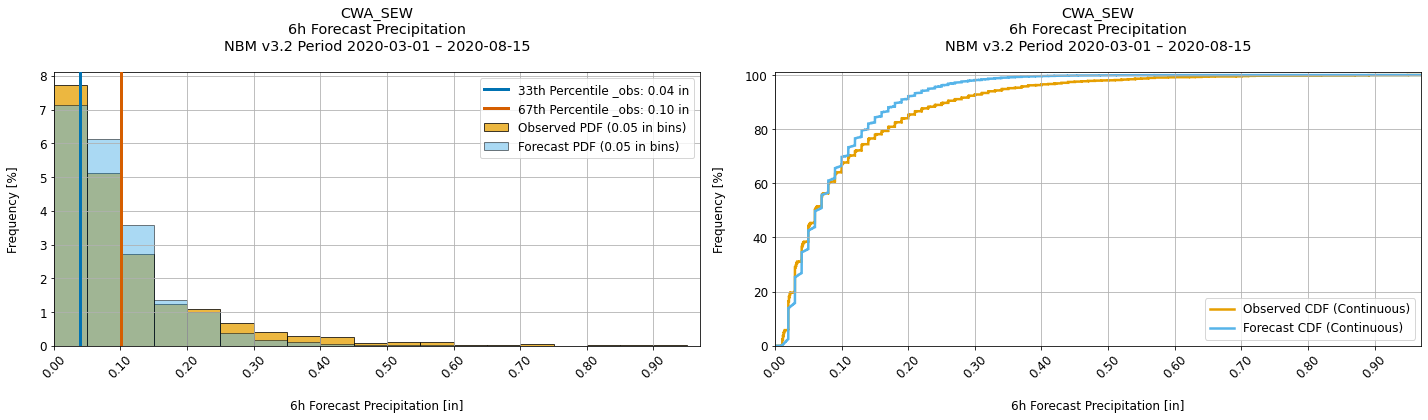

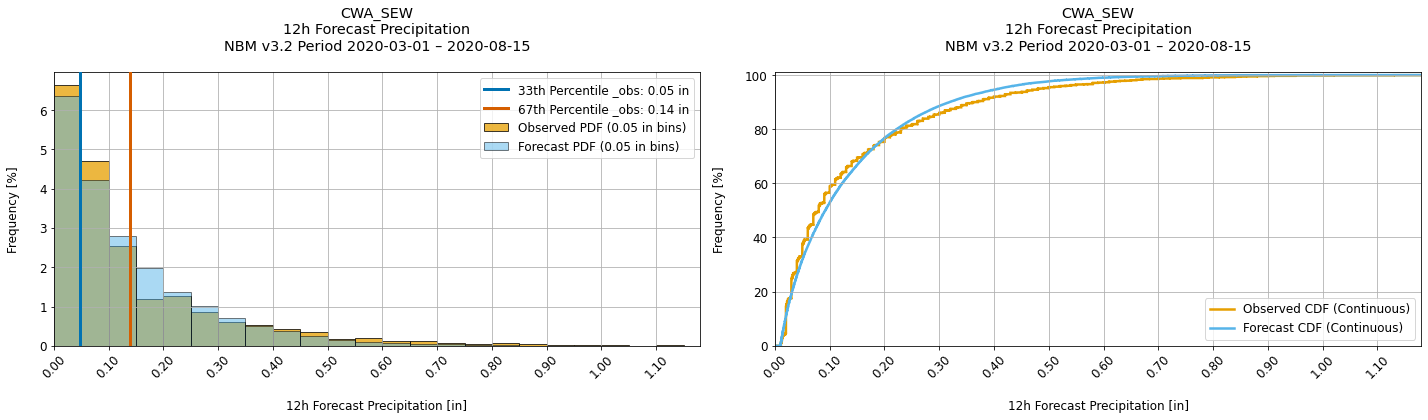

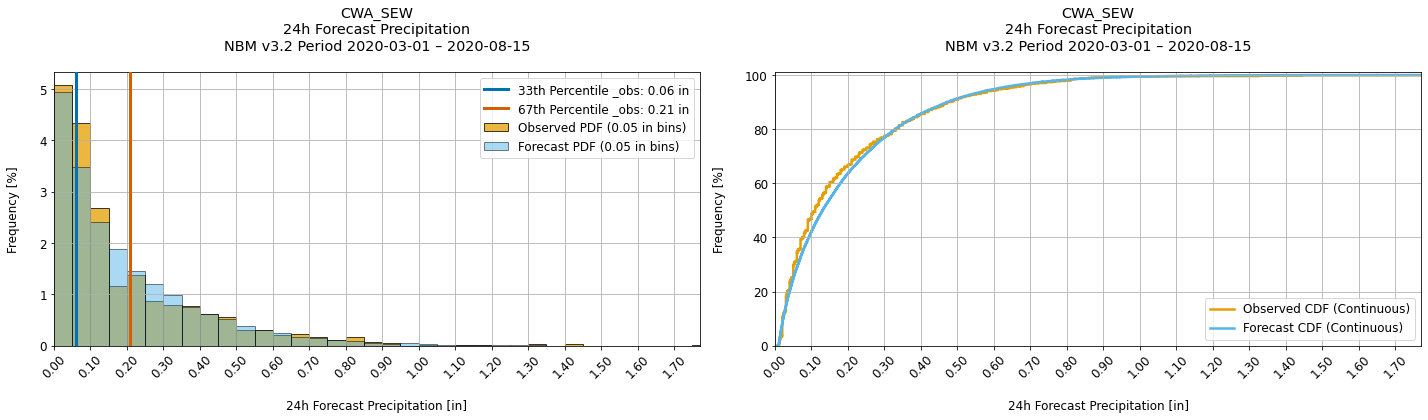

{6: array([0.        , 0.04      , 0.10087598, 1.02      ]),
 12: array([0.        , 0.04812598, 0.14      , 1.23031496]),
 24: array([0.        , 0.06      , 0.20984252, 1.82125984])}

In [12]:
thresh_id = nbm_funcs._thresh_id = {'Small':[0, 1], 'Medium':[1, 2], 'Large':[2, 3], 'All':[0, 3]}

# 33rd, 67th percentile determined above
thresholds = nbm_funcs._thresholds = {interval:nbm_funcs.apcp_dist_plot(obs, nbm, interval, show=True) 
              for interval in [6, 12, 24]}

thresholds

***
***
# Reorganize the data for analysis:
#### Isolate the forecasts by accumulation interval and lead time

In [22]:
plist = np.arange(1, 100)

data = []
for interval in [6, 12, 24]:
    
    pkeys = np.array([k for k in nbm.keys() if '%dhr_'%interval in k])
    pkeys = np.array([k for k in pkeys if '%' in k])
    pkeys = pkeys[np.argsort([int(k.split('_')[-1].split('%')[0]) for k in pkeys])]
    
    for lead_time in np.arange(interval, lead_time_end, 6):
        
        for esize in ['Small', 'Medium', 'Large']:
            
            thresh = [thresholds[interval][thresh_id[esize][0]], 
                      thresholds[interval][thresh_id[esize][1]]]
        
            print('\rProcessing interval %d lead %dh'%(interval, lead_time), end='')

            # We need to break out the verification to each lead time,
            # but within each lead time we have a number of valid times.
            # At each lead time, valid time, isolate the forecast verification

            # Combine the datasets to make it easier to work with
            idata = nbm[nbm['LeadTime'] == lead_time].merge(obs, on=['ValidTime', 'Site']).drop(columns='LeadTime')

            # Subset for event size using the observed precip
            iobs = idata['%dh_precip_in'%interval]
            # Do the trimming of the selected dataset
            idata = idata[((iobs >= thresh[0]) & (iobs < thresh[1]))]
            del iobs
            
            for itime in idata.index:

                try:
                    prob_fx = idata.loc[itime, pkeys]
                    mean_fx = np.nanmean(prob_fx)
                    std_fx = np.nanstd(prob_fx)
                    med_fx = idata.loc[itime, 'APCP%dhr_surface_50%% level'%interval]
                    det_fx = idata.loc[itime, 'APCP%dhr_surface'%interval]

                    # Optional - leave as nan?
                    det_fx = det_fx if ~np.isnan(det_fx) else 0.

                    verif_ob = idata.loc[itime, '%dh_precip_in'%interval]
                    
                    verif_rank = np.searchsorted(prob_fx, verif_ob, 'right')                    
                    verif_rank_val = prob_fx[verif_rank-1]
                    verif_rank_error = verif_rank_val - verif_ob
                    
                    verif_rank = 101 if ((verif_rank >= 99) & (verif_ob > verif_rank_val)) else verif_rank
                    verif_rank = -1 if ((verif_rank <= 1) & (verif_ob < verif_rank_val)) else verif_rank
                    
                    det_rank = np.searchsorted(prob_fx, det_fx, 'right')
                    det_error = det_fx - verif_ob

                except:
                    pass
                    # print('failed', itime)

                else:
                    if ((verif_ob > 0.) & ~np.isnan(verif_rank_val)):

                        data.append([
                            # Indexers
                            interval, lead_time, itime[0], itime[1], esize,

                            # Verification and deterministic
                            verif_ob, det_fx, det_rank, det_error,

                            # Probabilistic
                            verif_rank, verif_rank_val, verif_rank_error, 
                            med_fx, mean_fx, std_fx])

data = pd.DataFrame(data, columns=['Interval', 'LeadTime', 'ValidTime', 'Site', 'EventSize',
                'verif_ob', 'det_fx', 'det_rank', 'det_error',
                'verif_rank', 'verif_rank_val', 'verif_rank_error', 
                'med_fx', 'mean_fx', 'std_fx'])

print('\n\nAvailable keys:\n\t\t{}\nn rows: {}'.format('\n\t\t'.join(data.keys()), len(data)))

Processing interval 24 lead 258h

Available keys:
		Interval
		LeadTime
		ValidTime
		Site
		EventSize
		verif_ob
		det_fx
		det_rank
		det_error
		verif_rank
		verif_rank_val
		verif_rank_error
		med_fx
		mean_fx
		std_fx
n rows: 46144


***
***
# Create Bulk Temporal Stats Plots
#### Reliability diagrams, bias over time, rank over time, etc.

In [14]:
short, long = 0, 120
plot_type = 'Verification'
plot_var = 'verif_rank'
esize = 'All'

for interval in [6, 12, 24]:

    kwargs = {'_interval':interval, '_esize':esize,
             '_short':short, '_long':long,
             '_plot_type':plot_type, '_plot_var':plot_var}
    
    nbm_funcs.histograms_verif_rank(data, **kwargs, show=False)

CWA_SEW_6h_szAll_lead0-120h.rankPDF.verification.png
CWA_SEW_12h_szAll_lead0-120h.rankPDF.verification.png
CWA_SEW_24h_szAll_lead0-120h.rankPDF.verification.png


#### Plot a reliability diagram style CDF to evaluate percentile rankings

In [15]:
short, long = 0, 120
plot_type = 'Verification'
plot_var = 'verif_rank'
esize = 'All'

for interval in [6, 12, 24]:

    kwargs = {'_interval':interval, '_esize':esize,
             '_short':short, '_long':long,
             '_plot_type':plot_type, '_plot_var':plot_var}

    nbm_funcs.reliability_verif_cdf_multistation(data, **kwargs, show=False)

CWA_SEW_6h_szAll_lead0-120h.reliabilityCDF.verification.png
CWA_SEW_6h_szAll_lead0-120h.reliabilityCDF.verification.png
CWA_SEW_12h_szAll_lead0-120h.reliabilityCDF.verification.png
CWA_SEW_12h_szAll_lead0-120h.reliabilityCDF.verification.png
CWA_SEW_24h_szAll_lead0-120h.reliabilityCDF.verification.png
CWA_SEW_24h_szAll_lead0-120h.reliabilityCDF.verification.png


#### Produce bias, ME, MAE, and percentile rank plots as they evolve over time
This helps illustrate at what leads a dry/wet bias may exist and how severe it may be<br>
Adds value in interpreting the CDF reliability diagrams

In [16]:
short, long = 0, 120
esize = 'All'

for interval in [6, 12, 24]:

    kwargs = {'_interval':interval, '_esize':esize,
             '_short':short, '_long':long}

    nbm_funcs.rank_over_leadtime(data, **kwargs, show=False)

CWA_SEW_6h_szAll_lead0-120h.rank_err_overtime.png
CWA_SEW_6h_szAll_lead0-120h.rank_err_overtime.png
CWA_SEW_12h_szAll_lead0-120h.rank_err_overtime.png
CWA_SEW_12h_szAll_lead0-120h.rank_err_overtime.png
CWA_SEW_24h_szAll_lead0-120h.rank_err_overtime.png
CWA_SEW_24h_szAll_lead0-120h.rank_err_overtime.png


In [17]:
# Create maps of rank at each station over the CWA with mean verif and mean det